<a href="https://colab.research.google.com/github/wholenote/twitter_spambot_detection/blob/main/botdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Twitter Bot Detection**


---


### CSCE 489 Semester Project
Brian, Casey, & Rhonda



##Mount Google Drive

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Dependencies

In [104]:
import pandas as pd
import numpy as np

from dateutil.parser import parse
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, ComplementNB

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

##Dataset: Preprocessing
We used part of the cresci-2017 dataset from https://botometer.osome.iu.edu/bot-repository/datasets.html#cresci. Specifically, we used the genuine accounts and traditional spambots 1 data. 

In [5]:
# Genuine Account CSV files
path_genuineAccounts_USERS = 'gdrive/Shareddrives/CSCE489 Project/genuine_accounts.csv/users.csv'
path_genuineAccounts_TWEETS = 'gdrive/Shareddrives/CSCE489 Project/genuine_accounts.csv/tweets.csv'

# Spam Bot Account CSV files
path_spamBots_USERS = 'gdrive/Shareddrives/CSCE489 Project/traditional_spambots_1.csv/users.csv'
path_spamBots_TWEETS = 'gdrive/Shareddrives/CSCE489 Project/traditional_spambots_1.csv/tweets.csv'

df_genuine_users = pd.read_csv(path_genuineAccounts_USERS) 
df_genuine_tweets = pd.read_csv(path_genuineAccounts_TWEETS)
df_spamBots_users = pd.read_csv(path_spamBots_USERS)
df_spambots_tweets = pd.read_csv(path_spamBots_TWEETS)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Removing the last 2 columns to have consistent columns between both spam and genuine dataset

In [6]:
df_genuine_users.drop(columns=['test_set_1', 'test_set_2'], inplace=True)

Preview of the dataset: users' information and tweets

In [7]:
# Dataset Preview
print(df_genuine_users.head())
print(df_genuine_tweets.head())

           id               name  ...           crawled_at              updated
0  1502026416    TASUKU HAYAKAWA  ...  2015-05-02 06:41:46  2016-03-15 15:53:47
1  2492782375              ro_or  ...  2015-05-01 17:20:27  2016-03-15 15:53:48
2   293212315           bearclaw  ...  2015-05-01 18:48:28  2016-03-15 15:53:48
3   191839658  pocahontas farida  ...  2015-05-01 13:55:16  2016-03-15 15:53:48
4  3020965143           Ms Kathy  ...  2015-05-02 01:17:32  2016-03-15 15:53:48

[5 rows x 40 columns]
                   id  ...              updated
0  593932392663912449  ...  2015-05-01 12:57:19
1  593895316719423488  ...  2015-05-01 12:57:19
2  593880638069018624  ...  2015-05-01 12:57:19
3  593847955536252928  ...  2015-05-01 12:57:19
4  593847687847350272  ...  2015-05-01 12:57:19

[5 rows x 25 columns]


In [8]:
for column in df_spambots_tweets.columns:
  print(column + ": " + str(df_genuine_tweets.loc[0, column]))
# print(df_spambots_tweets.head(1))

id: 593932392663912449
text: RT @morningJewshow: Speaking about Jews and comedy tonight at Temple Emanu-El in San Francisco. In other words, my High Holidays.
source: <a href="http://tapbots.com/tweetbot" rel="nofollow">Tweetbot for iΟS</a>
user_id: 678033.0
truncated: nan
in_reply_to_status_id: 0.0
in_reply_to_user_id: 0.0
in_reply_to_screen_name: nan
retweeted_status_id: 5.939321685245338e+17
geo: nan
place: nan
contributors: nan
retweet_count: 1.0
reply_count: 0.0
favorite_count: 0.0
favorited: nan
retweeted: nan
possibly_sensitive: nan
num_hashtags: 0.0
num_urls: 0.0
num_mentions: 1.0
created_at: Fri May 01 00:18:11 +0000 2015
timestamp: 2015-05-01 02:18:11
crawled_at: 2015-05-01 12:57:19
updated: 2015-05-01 12:57:19


## Feature Extraction
Creating a vector of features for each user. Each user vector will contain the features shown in Table 3 below. The features were determined to the most useful characterisitcs for bot dectection models. Table 3 is obtained from: https://doi.org/10.1016/j.cose.2020.101715

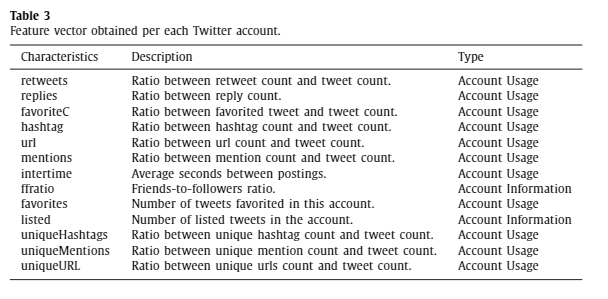

### X Vector (Features)
Combine the genuine and spam datasets into one dataframe. x_df are the genuine and spam user CSVs combined. tweets_df are the genuine and spam tweets CSVs combined.

In [9]:
x_df = df_genuine_users.append(df_spamBots_users)
tweets_df = df_genuine_tweets.append(df_spambots_tweets)

Then, the features are calculated from the user information and user tweets dataframes

In [10]:
def change_ts(ts):
  cts = 0
  try:
    cts = parse(ts).timestamp()
  except:
    cts = int(ts[:-1]) / 1000
  return cts

def get_intertime(df):
  tweet_timestamps = []
  
  for index, row in df.iterrows():
    tweet_timestamps.append(change_ts(str(row["created_at"])))

  # df["created_at"].values.tolist().map(change_ts)
  
  tweet_timestamps.sort()
  tts_diff = np.diff(np.array(tweet_timestamps))
  return sum(tts_diff) / (len(tts_diff) if len(tts_diff) != 0 else 1)

In [93]:
x_vector = []

for index, row in x_df.iterrows():
  # current user's id
  usr = row['id']
  usr_tweets_df = tweets_df.loc[tweets_df["user_id"] == usr]
  tweet_count = len(usr_tweets_df) if len(usr_tweets_df) != 0 else 1

  # calculate features
  retweets = len(usr_tweets_df[usr_tweets_df.retweeted_status_id != 0]) / tweet_count
  replies = len(usr_tweets_df[usr_tweets_df.in_reply_to_status_id != 0]) / tweet_count
  favoriteC = row["favourites_count"] / tweet_count
  hashtag = sum(usr_tweets_df["num_hashtags"].values.tolist()) / tweet_count
  url = sum(usr_tweets_df["num_urls"].values.tolist()) / tweet_count
  mentions = sum(usr_tweets_df["num_mentions"].values.tolist()) / tweet_count
  intertime = get_intertime(usr_tweets_df)
  ffratio = row["friends_count"]/(row["followers_count"] if row["followers_count"] != 0 else 1)
  favorites = row["favourites_count"]
  listed = row["listed_count"]
  uniqueHashtags = -1
  uniqueMentions = -1
  uniqueURL = -1

  usr_features = [retweets, replies, favoriteC, hashtag, url, mentions, intertime, ffratio, favorites, listed]
  x_vector.append(usr_features)


In [96]:
for i in range(5):
  print(x_vector[i])

[0.0, 0.0, 265.0, 0.0, 0.0, 0.0, 0.0, 1.5961538461538463, 265, 1]
[0.0, 0.0, 3972.0, 0.0, 0.0, 0.0, 0.0, 1.4696969696969697, 3972, 5]
[0.0, 0.0, 1185.0, 0.0, 0.0, 0.0, 0.0, 1.0662650602409638, 1185, 0]
[0.3391304347826087, 0.27670807453416146, 18.727950310559006, 0.14751552795031056, 0.09751552795031056, 0.825776397515528, 534.9173656415036, 0.4363879003558719, 60304, 101]
[0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 3.761904761904762, 5, 0]


Then, we normalize the input data.

In [12]:
x = preprocessing.normalize(x_vector)

Preview of features after extraction and normalizing.

In [91]:
df = pd.DataFrame(x, columns=['retweets', 'replies', 'favoriteC', 'hashtag', 'url', 'mentions', 'intertime', 'ffratio', 'favorites', 'listed'])
pd.set_option('display.max_columns', None)
print(df.head())
pd.reset_option('max_columns')

   retweets   replies  favoriteC   hashtag           url  mentions  intertime  \
0  0.000047  0.000002   0.000242  0.000024  1.138270e-05  0.000056   0.672162   
1  0.000000  0.000000   0.707088  0.000000  0.000000e+00  0.000000   0.000000   
2  0.000000  0.000000   0.707107  0.000000  0.000000e+00  0.000000   0.000000   
3  0.000000  0.000000   0.000000  0.000000  2.582579e-01  0.000000   0.000000   
4  0.000000  0.000000   0.000000  0.000000  4.944606e-07  0.000000   1.000000   

    ffratio  favorites        listed  
0  0.000131   0.740404  2.119680e-04  
1  0.000481   0.707088  7.239811e-03  
2  0.000014   0.707107  1.533374e-04  
3  0.966076   0.000000  0.000000e+00  
4  0.000003   0.000000  4.944606e-07  


### Y Vector (Labels)
**0 represents genuine (human account), 1 represents spam (bot account)**; the labels are created by combining np.zeros and np.ones.

In [13]:
y = np.zeros(len(df_genuine_users), dtype=int).tolist() + np.ones(len(df_spamBots_users), dtype=int).tolist()

## Split Train/Test Data

In [70]:
x, y = shuffle(x, y)
x_train, x_test, y_train, y_test = train_test_split(x, y)

## Support Vector Machine

### Linear Kernel

In [71]:
SVC_linear_classifier = SVC(kernel='linear')
SVC_linear_classifier.fit(x_train, y_train)

y_pred = SVC_linear_classifier.predict(x_test)

# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred, target_names=['Human', 'Bot']))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

              precision    recall  f1-score   support

       Human       1.00      0.85      0.92       874
         Bot       0.65      1.00      0.79       245

    accuracy                           0.88      1119
   macro avg       0.83      0.93      0.85      1119
weighted avg       0.92      0.88      0.89      1119

True Negatives:  744
False Positives:  130
False Negatives:  0
True Positives:  245


###Polynominal Kernel

In [72]:
SVC_poly_classifier = SVC(kernel='poly')
SVC_poly_classifier.fit(x_train, y_train)

y_pred = SVC_poly_classifier.predict(x_test)

# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred, target_names=['Human', 'Bot']))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

              precision    recall  f1-score   support

       Human       1.00      0.87      0.93       874
         Bot       0.69      1.00      0.81       245

    accuracy                           0.90      1119
   macro avg       0.84      0.94      0.87      1119
weighted avg       0.93      0.90      0.91      1119

True Negatives:  764
False Positives:  110
False Negatives:  1
True Positives:  244


## Random Forest Classifier

In [73]:
rfc_model = RandomForestClassifier()
rfc_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [74]:
y_pred = rfc_model.predict(x_test)

In [76]:
print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))

              precision    recall  f1-score   support

       Human       0.99      0.99      0.99       874
         Bot       0.97      0.97      0.97       245

    accuracy                           0.99      1119
   macro avg       0.98      0.98      0.98      1119
weighted avg       0.99      0.99      0.99      1119



In [77]:
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

[[867   7]
 [  7 238]]
True Negatives: 867, False Positives: 7, False Negatives: 7, True Positives: 238


## Logistic Regression

In [78]:
logreg_model = LogisticRegression()
logreg_model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [79]:
y_pred = logreg_model.predict(x_test)

In [81]:
print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))

              precision    recall  f1-score   support

       Human       1.00      0.87      0.93       874
         Bot       0.68      1.00      0.81       245

    accuracy                           0.90      1119
   macro avg       0.84      0.93      0.87      1119
weighted avg       0.93      0.90      0.90      1119



In [82]:
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

[[760 114]
 [  0 245]]
True Negatives: 760, False Positives: 114, False Negatives: 0, True Positives: 245


## Naive Bayes

### Gaussian NB

In [83]:
n_bayes = GaussianNB()
n_bayes.fit(x_train, y_train) 

GaussianNB(priors=None, var_smoothing=1e-09)

In [84]:
expected = y_test
predicted = n_bayes.predict(x_test)

In [85]:
print(classification_report(expected, predicted, target_names=['Human', 'Bot']))

              precision    recall  f1-score   support

       Human       1.00      0.87      0.93       874
         Bot       0.68      0.99      0.81       245

    accuracy                           0.90      1119
   macro avg       0.84      0.93      0.87      1119
weighted avg       0.93      0.90      0.90      1119



In [86]:
print(confusion_matrix(expected, predicted))

[[761 113]
 [  3 242]]


In [87]:
tn, fp, fn, tp = confusion_matrix(expected, predicted).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

True Negatives: 761, False Positives: 113, False Negatives: 3, True Positives: 242


### Complement NB

In [117]:
cn_bayes = ComplementNB()
cn_bayes.fit(x_train, y_train)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [118]:
y_pred = cn_bayes.predict(x_test)

In [119]:
print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))

              precision    recall  f1-score   support

       Human       1.00      0.80      0.89       874
         Bot       0.59      1.00      0.74       245

    accuracy                           0.85      1119
   macro avg       0.79      0.90      0.82      1119
weighted avg       0.91      0.85      0.86      1119



In [120]:
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

[[702 172]
 [  0 245]]
True Negatives: 702, False Positives: 172, False Negatives: 0, True Positives: 245


## Neural Network

In [111]:
# parameters
batch_size = 32
epochs = 20

In [112]:
model = tf.keras.Sequential([
  layers.Dense(10),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(np.array(x_train),
          np.array(y_train),
          batch_size=batch_size,
          epochs=epochs)

Epoch 1/20
105/105 [==============================] - 1s 2ms/step - loss: 0.4489 - accuracy: 0.7990
Epoch 2/20
105/105 [==============================] - 0s 2ms/step - loss: 0.2078 - accuracy: 0.8621
Epoch 3/20
105/105 [==============================] - 0s 2ms/step - loss: 0.1913 - accuracy: 0.8961
Epoch 4/20
105/105 [==============================] - 0s 2ms/step - loss: 0.1866 - accuracy: 0.8787
Epoch 5/20
105/105 [==============================] - 0s 2ms/step - loss: 0.1806 - accuracy: 0.9081
Epoch 6/20
105/105 [==============================] - 0s 2ms/step - loss: 0.1731 - accuracy: 0.8835
Epoch 7/20
105/105 [==============================] - 0s 1ms/step - loss: 0.1663 - accuracy: 0.9020
Epoch 8/20
105/105 [==============================] - 0s 1ms/step - loss: 0.1524 - accuracy: 0.9336
Epoch 9/20
105/105 [==============================] - 0s 2ms/step - loss: 0.1396 - accuracy: 0.9361
Epoch 10/20
105/105 [==============================] - 0s 2ms/step - loss: 0.1633 - accuracy: 0.9203

In [113]:
loss, accuracy = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
print("Accuracy: ", accuracy)

35/35 [==============================] - 0s 1ms/step - loss: 0.1280 - accuracy: 0.9508
Accuracy:  0.9508489966392517


In [114]:
y_pred = model.predict_classes(x_test, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [115]:
print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))

              precision    recall  f1-score   support

       Human       1.00      0.94      0.97       874
         Bot       0.82      1.00      0.90       245

    accuracy                           0.95      1119
   macro avg       0.91      0.97      0.93      1119
weighted avg       0.96      0.95      0.95      1119



In [116]:
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

[[820  54]
 [  1 244]]
True Negatives: 820, False Positives: 54, False Negatives: 1, True Positives: 244
